# SVM 实战
## 实战一：利用自定义SMO算法训练
### 步骤一：导入相应库

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler

### 步骤二：数据获取及特征标准化

In [77]:
#获取数据
dataset = pd.read_csv('./Social_Network_Ads.csv')
x = dataset.iloc[:, [2, 3]].values
x = x.astype(float)
y = dataset.iloc[:, 4].values

#将0替换为-1
for i in range(len(y)):
    if y[i]==0:
        y[i]=-1

# 数据集划分
train_data, test_data, train_label, test_label = train_test_split(x, y, test_size = 0.25, random_state = 61)

#特征标准化
sc = StandardScaler()
train_data = sc.fit_transform(train_data)
test_data = sc.transform(test_data)

### 步骤三：SMO算法定义
- 该算法理解可参考李航《统计学习方法》SMO算法部分
- 也可参考博客：https://www.cnblogs.com/zgqcn/p/15092351.html
- 代码注释以书本为准

In [103]:
class smo:
    def __init__(self, max_iter=100, kernel='linear'):
        '''
        input:max_iter(int):最大训练轮数
              kernel(str):核函数，等于'linear'表示线性，等于'poly'表示多项式
        '''
        self.max_iter = max_iter
        self._kernel = kernel
         
    # 初始化模型
    def init_args(self, features, labels):
        self.m, self.n = features.shape                  # 特征数据的行列数量
        self.X = features                                # 输入数据
        self.Y = labels                                  # 标签
        self.b = 0.0                                     # 初始化 b
                                                         # 将Ei保存在一个列表里
        self.alpha = np.ones(self.m)                     # alpha的数量等于训练数据的数量
        self.E = [self._E(i) for i in range(self.m)]     # 记录每个训练数据的误差                                           
        self.C = 1.0                                     # 错误惩罚参数
   
    # kkt条件    
    # 根据课本(7.111)- (7.113)定义
    def _KKT(self, i):
        y_g = self._g(i) * self.Y[i]
        if self.alpha[i] == 0:
            return y_g >= 1
        elif 0 < self.alpha[i] < self.C:
            return y_g == 1
        else:
            return y_g <= 1

    # g(x)预测值，输入xi
    # 根据课本(7.104)定义
    def _g(self, i):                                 
        r = self.b
        for j in range(self.m):
            r += self.alpha[j] * self.Y[j] * self.kernel(self.X[i], self.X[j])
        return r

    # 核函数,多项式添加二次项即可
    def kernel(self, x1, x2):
        if self._kernel == 'linear':
            return sum([x1[k] * x2[k] for k in range(self.n)])
        elif self._kernel == 'poly':
            return (sum([x1[k] * x2[k] for k in range(self.n)]) + 1)**2    
        return 0

    # E（x）为g(x)对输入x的预测值和y的差
    # 根据课本(7.105)定义
    def _E(self, i):
        return self._g(i) - self.Y[i]

    # 初始alpha，选择2个alpha参数
    def _init_alpha(self):
        # 外层循环首先遍历所有满足0<a<C的样本点，检验是否满足KKT
        index_list = [i for i in range(self.m) if 0 < self.alpha[i] < self.C]
        # 否则遍历整个训练集
        non_satisfy_list = [i for i in range(self.m) if i not in index_list]
        index_list.extend(non_satisfy_list)
        for i in index_list:
            if self._KKT(i):
                continue
            E1 = self.E[i]
            # 如果E1是正的，选择最小的Ej作为E2；如果E1是负的，选择最大的Ej作为E2
            # 参考书本p147
            if E1 >= 0:
                j = min(range(self.m), key=lambda x: self.E[x])
            else:
                j = max(range(self.m), key=lambda x: self.E[x])
            return i, j

    # 根据约束条件裁剪
    # 根据课本(7.108)定义
    def _compare(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha

    #训练
    def fit(self, features, labels):
        '''
        input:features(ndarray):特征
              label(ndarray):标签
        '''
        self.init_args(features, labels)
        for t in range(self.max_iter):
            i1, i2 = self._init_alpha()
            # 边界，根据课本p145的公式定义
            if self.Y[i1] == self.Y[i2]:
                L = max(0, self.alpha[i1] + self.alpha[i2] - self.C)
                H = min(self.C, self.alpha[i1] + self.alpha[i2])
            else:
                L = max(0, self.alpha[i2] - self.alpha[i1])
                H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])
            E1 = self.E[i1]
            E2 = self.E[i2]
            # eta = K11 + K22 - 2K12，根据课本(7.107)定义
            eta = self.kernel(self.X[i1], self.X[i1]) + self.kernel(self.X[i2], self.X[i2]) - 2 * self.kernel(self.X[i1], self.X[i2])
            if eta <= 0:
                continue
            alpha2_new_unc = self.alpha[i2] + self.Y[i2] * (E2 - E1) / eta  # 根据课本(7.106)定义
            alpha2_new = self._compare(alpha2_new_unc, L, H)                # 根据课本(7.108)定义
            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (self.alpha[i2] - alpha2_new) # 根据课本(7.109)定义
            b1_new = -E1 - self.Y[i1] * self.kernel(self.X[i1], self.X[i1]) * (alpha1_new-self.alpha[i1]) - self.Y[i2] * self.kernel(self.X[i2], self.X[i1]) * (alpha2_new-self.alpha[i2])+ self.b  # 根据课本(7.115)定义 
            b2_new = -E2 - self.Y[i1] * self.kernel(self.X[i1], self.X[i2]) * (alpha1_new-self.alpha[i1]) - self.Y[i2] * self.kernel(self.X[i2], self.X[i2]) * (alpha2_new-self.alpha[i2])+ self.b  # 根据课本(7.116)定义 
            if 0 < alpha1_new < self.C:    # 根据书本p148的约束条件
                b_new = b1_new
            elif 0 < alpha2_new < self.C:
                b_new = b2_new
            else:
                # 选择中点
                b_new = (b1_new + b2_new) / 2
            # 更新参数
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new
            self.E[i1] = self._E(i1)   # 根据课本(7.117)定义
            self.E[i2] = self._E(i2)     

      
    def predict(self, data):
        '''
        input:data(ndarray):单个样本
        output:预测为正样本返回+1，负样本返回-1
        '''
        r = self.b
        for i in range(self.m):
            r += self.alpha[i] * self.Y[i] * self.kernel(data, self.X[i])
        if r > 0:
            return 1
        else:
            return -1

### 步骤四：模型训练

In [104]:
classifier = smo()
classifier.fit(train_data, train_label)

### 步骤五：模型测试

In [114]:
for i in range(len(test_data)):
    y_pred = classifier.predict(test_data[i])
    print('Predict：{} \t True：{}'.format(y_pred, test_label[i]))

Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：1 	 True：1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：1 	 True：1
Predict：-1 	 True：-1
Predict：-1 	 True：1
Predict：-1 	 True：-1
Predict：-1 	 True：1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：1 	 True：1
Predict：-1 	 True：1
Predict：-1 	 True：1
Predict：-1 	 True：1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：1 	 True：-1
Predict：-1 	 True：1
Predict：-1 	 True：-1
Predict：1 	 True：1
Predict：-1 	 True：-1
Predict：1 	 True：1
Predict：1 	 True：1
Predict：1 	 True：1
Predict：-1 	 True：-1
Predict：1 	 True：1
Predict：-1 	 True：1
Predict：1 	 True：1
Predict：1 	 True：1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Predict：-1 	 True：1
Predict：-1 	 True：1
Predict：1 	 True：1
Predict：-1 	 True：-1
Predict：-1 	 True：-1
Pre

## 实战二：SVM Model for Social Network Ads
> 本实战利用`sklearn.svm.SVC`库进行SVM  

- SVM、SVC、SVR 三者的关系：
    - SVM = Support Vector Machine 是支持向量
    - SVC = Support Vector Classification 就是支持向量机用于分类，
    - SVR= Support Vector Regression 就是支持向量机用于回归分析
- sklearn中的算法
    - svm.LinearSVC Linear Support Vector Classification.
    - svm.LinearSVR Linear Support Vector Regression.
    - svm.NuSVC Nu-Support Vector Classification.
    - svm.NuSVR Nu Support Vector Regression.
    - svm.OneClassSVM Unsupervised Outlier Detection.
    - svm.SVC C-Support Vector Classification.
    - svm.SVR Epsilon-Support Vector Regression.

### 步骤1：导入相关库

In [117]:
import numpy as np # 线性代数
import matplotlib.pyplot as plt # 绘图
import pandas as pd # 数据预处理

### 步骤2：数据导入及预处理

In [119]:
# 数据集获取
dataset = pd.read_csv('./Social_Network_Ads.csv')
X = dataset.iloc[:, [2, 3]].values
X = X.astype(float)
y = dataset.iloc[:, 4].values

# 数据集划分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# 数据特征化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### 步骤3：定义`线性`SVM模型

In [120]:
# 使用线性核函数性将 SVM 对训练集进行拟合
from sklearn.svm import SVC
classifier = SVC(kernel='linear',random_state=0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

#### 步骤3.1：利用已训练`线性`SVM模型测试

In [122]:
y_pred = classifier.predict(X_test)

#### 步骤3.2：计算混淆矩阵

In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[66  2]
 [ 8 24]]


#### 步骤3.3：训练结果可视化

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


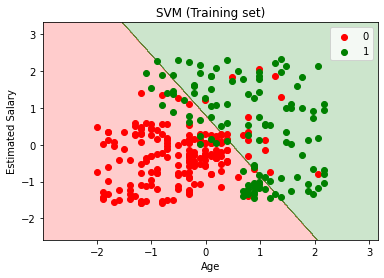

In [169]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train

# 坐标向量中生成坐标矩阵
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01), # x轴
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01)) # y轴

# 绘制等高线图
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), # 对坐标矩阵每个点进进行预测
             alpha = 0.2, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

for i, j in enumerate(np.unique(y_set)):  # np.unique去除重复数据
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
    
plt.title('SVM (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

#### 步骤3.4：测试结果可视化

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


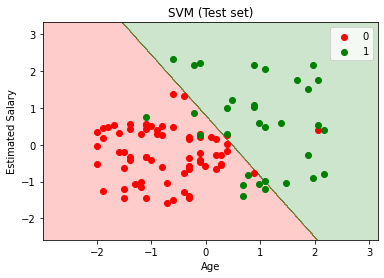

In [171]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.2, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

- 正如我们所看到的，由于这个分类器的线性特性，模型做出了一些不正确的预测（根据混淆矩阵和图表，有 10 个错误的预测）。 
- 现在让我们尝试使用不同的内核类型，看看它是否能做出更好的预测

### 步骤4：定义`非线性`SVM模型
- 核函数利用高斯核函数`RBF`

In [172]:
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',random_state=0)
classifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False)

#### 步骤4.1：利用已训练非`线性SVM`模型测试

In [173]:
y_pred = classifier.predict(X_test)

#### 步骤4.2：计算混淆矩阵

In [175]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[64  4]
 [ 3 29]]


#### 步骤4.3：训练结果可视化

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


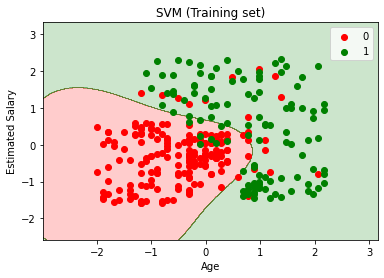

In [177]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.2, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

#### 步骤4.4：测试结果可视化

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


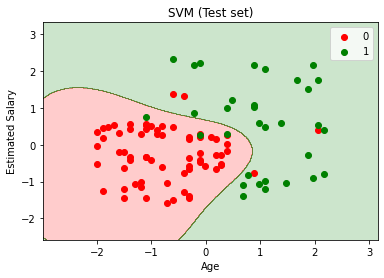

In [179]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.2, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

- 正如我们从上图中观察到的，内核为 rbf 的分类器做出了更好的预测，只有 7 个错误的预测
- 因此，与 Logistic 回归和 K-NN 相比，这仍然是一个更好的模型，可以对因变量进行有用的预测

#### 实战参考
- [SVM Model for Social Network Ads](https://www.kaggle.com/farhanmd29/svm-model-for-social-network-ads)
- [序列最小优化算法（smo算法）](https://www.cnblogs.com/lsm-boke/p/12317200.html)